In [1]:
from seinfeld_playground import load_corpus, getSceneData
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = load_corpus()
print("There are %d sentances, %d funny, %d not funny" % (len(df), sum(df.is_funny), len(df) - sum(df.is_funny)))
df.head(2)

There are 46497 sentances, 13560 funny, 32937 not funny


,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,1.106,486,"Here's what happened last week, incase you mi..."
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,3.074,486,"George and I went up to NBC, and we told them..."


In [3]:
df = getSceneData(df)
df.head()

,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt,time_from_prev,new_scene,scene_text,scene_characters,n_scene_characters
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,1.106,486,"Here's what happened last week, incase you mi...",0.000,True,"Here's what happened last week, incase you mi...","{JERRY, MORTY}",2
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,3.074,486,"George and I went up to NBC, and we told them...",0.024,False,"Here's what happened last week, incase you mi...","{JERRY, MORTY}",2
2,JERRY,7.822,The Watch,6,False,NaN,1.378,2,6,4,6.444,486,We're waiting to sign the contract.,0.073,False,"Here's what happened last week, incase you mi...","{JERRY, MORTY}",2
3,JERRY,9.364,The Watch,6,False,NaN,1.518,3,8,4,7.846,486,"Jerry, I want you to sign that contract.",0.024,False,"Here's what happened last week, incase you mi...","{JERRY, MORTY}",2
4,JERRY,10.881,The Watch,6,False,NaN,1.517,4,4,4,9.364,486,We're gonna sign it.,0.000,False,"Here's what happened last week, incase you mi...","{JERRY, MORTY}",2


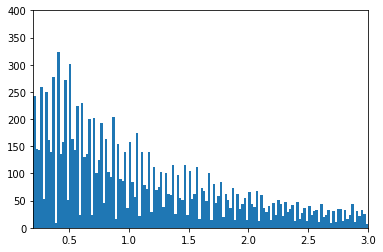

In [4]:
plt.hist(df['time_from_prev'], bins=([i / 100 for i in range(0,302,2)]) + ([10,30,50,100]))
plt.xlim(0.2,3)
plt.ylim(0,400)
plt.show()

Try to decide on thershold, it's pretty hard.  
I preffer not to have FP so Will pick 1.8

In [4]:
df.head()

,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt,time_from_prev
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,1.106,486,"Here's what happened last week, incase you mi...",0.000
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,3.074,486,"George and I went up to NBC, and we told them...",0.055
2,JERRY,7.822,The Watch,6,False,NaN,1.378,2,6,4,6.444,486,We're waiting to sign the contract.,0.053
3,JERRY,9.364,The Watch,6,False,NaN,1.518,3,8,4,7.846,486,"Jerry, I want you to sign that contract.",0.769
4,JERRY,10.881,The Watch,6,False,NaN,1.517,4,4,4,9.364,486,We're gonna sign it.,0.070


In [5]:
start = df.start
end = df.end
episode_num = df.episode_num
df['time_from_prev'] = np.array([0] + [start[i] - end[i - 1] if episode_num[i] == episode_num[i - 1] else 0 for i in range(1, len(start))])

In [7]:
df['new_scene'] = df['time_from_prev'] > 1.8 
df.loc[(df.time_from_prev == 0) & (df.start <= 2), 'new_scene'] = True
df.head(5)

,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt,time_from_prev,new_scene
0,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9,4,1.106,486,"Here's what happened last week, incase you mi...",0.000,True
1,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16,4,3.074,486,"George and I went up to NBC, and we told them...",0.024,False
2,JERRY,7.822,The Watch,6,False,NaN,1.378,2,6,4,6.444,486,We're waiting to sign the contract.,0.073,False
3,JERRY,9.364,The Watch,6,False,NaN,1.518,3,8,4,7.846,486,"Jerry, I want you to sign that contract.",0.024,False
4,JERRY,10.881,The Watch,6,False,NaN,1.517,4,4,4,9.364,486,We're gonna sign it.,0.000,False


In [5]:
df_kramer_start = df[(df.character == 'KRAMER') & (df.new_scene)] 
print('kramer first in secnce funny: ', sum(df_kramer_start.is_funny) / len(df_kramer_start))
print('total funny:', sum(df.is_funny) / len(df))

kramer first in secnce funny:  0.36054421768707484
total funny: 0.29163171817536615


# Scene

In [13]:
# merge scene text
text_for_scene = []
charcteres_scence = []
number_rows_scence = []
for i, row in df.iterrows():
    if row['new_scene']:
        text_for_scene.append(row['txt'])
        charcteres_scence.append(set([row.character]))
        number_rows_scence.append(1)
    else:
        text_for_scene[-1] += "\n" + row['txt']
        charcteres_scence[-1].add(row.character)
        number_rows_scence[-1] += 1
        
print(text_for_scene[107])
print(charcteres_scence[107])
print(number_rows_scence[107])
assert(len(number_rows_scence) == len(charcteres_scence) and len(charcteres_scence) == len(text_for_scene))

What is your name, seor?
Kramer.
So Seor Kramer,  what is this about?
Cigars.
Cigars?
Cigars.
What about cigars?
See, here, I...
I saved one of the cigar rings.
{'KRAMER', 'MAN'}
9


In [11]:
df[df.n_scene_characters == 1]

,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt,time_from_prev,new_scene,scene_text,scene_characters,n_scene_characters
306,MORTY,826.623,The Watch,6,True,827.2,2.295,306,7,4,824.328,486,What the hell is going on here?,1.812,True,What the hell is going on here?,{MORTY},1
351,KRAMER,975.234,The Watch,6,True,980.9,2.091,351,4,4,973.143,486,"These are good, huh?",1.803,True,"These are good, huh?",{KRAMER},1
486,JERRY,5.011,The Bubble Boy,7,True,2.3,4.391,0,11,4,0.620,489,Have you ever called someone and were disappo...,0.000,True,Have you ever called someone and were disappo...,{JERRY},1
487,JERRY,7.274,The Bubble Boy,7,False,NaN,2.193,1,4,4,5.081,489,You wanted the machine.,0.070,False,Have you ever called someone and were disappo...,{JERRY},1
488,JERRY,8.747,The Bubble Boy,7,False,NaN,1.397,2,4,4,7.350,489,You're always thrown off.,0.076,False,Have you ever called someone and were disappo...,{JERRY},1
489,JERRY,12.684,The Bubble Boy,7,True,10.1,3.866,3,10,4,8.818,489,"You go, ""Oh, I... I didn't know you were there.",0.071,False,Have you ever called someone and were disappo...,{JERRY},1
490,JERRY,17.519,The Bubble Boy,7,True,17.4,4.764,4,13,4,12.755,489,"I just wanted to leave a message saying, 'Sor...",0.071,False,Have you ever called someone and were disappo...,{JERRY},1
491,JERRY,21.424,The Bubble Boy,7,False,NaN,3.797,5,13,4,17.627,489,"So here's two people who hate each other, don...",0.108,False,Have you ever called someone and were disappo...,{JERRY},1
492,JERRY,24.894,The Bubble Boy,7,True,24.4,3.297,6,9,4,21.597,489,but the phone machine is like this relationsh...,0.173,False,Have you ever called someone and were disappo...,{JERRY},1
493,JERRY,27.763,The Bubble Boy,7,False,NaN,2.796,7,6,4,24.967,489,"keeping these marginal, brain-dead relationsh...",0.073,False,Have you ever called someone and were disappo...,{JERRY},1


In [10]:
for i in sorted(df.n_scene_characters.unique()):
    print('scene with %d charcters funny precentage: ' % i, sum(df[(df.n_scene_characters == i)].is_funny) / len(df[(df.n_scene_characters == i)]), 'amount: ', len(df[(df.n_scene_characters == i)]))
print('total funny:', sum(df.is_funny) / len(df))

scene with 1 charcters funny precentage:  0.5032030749519538 amount:  3122
scene with 2 charcters funny precentage:  0.2943139678615575 amount:  16180
scene with 3 charcters funny precentage:  0.27437231395611855 amount:  13263
scene with 4 charcters funny precentage:  0.259865005192108 amount:  7704
scene with 5 charcters funny precentage:  0.2531400966183575 amount:  3105
scene with 6 charcters funny precentage:  0.25443425076452597 amount:  1635
scene with 7 charcters funny precentage:  0.25895598771750256 amount:  977
scene with 8 charcters funny precentage:  0.2864864864864865 amount:  185
scene with 9 charcters funny precentage:  0.22510822510822512 amount:  231
scene with 10 charcters funny precentage:  0.2736842105263158 amount:  95
total funny: 0.29163171817536615


In [44]:
# Add to the df
df['scence_text'] = [text_for_scene[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['scence_charcteres'] = [charcteres_scence[i] for i in range(len(number_rows_scence)) for _ in range(number_rows_scence[i])]
df['n_scence_charcteres'] = df.scence_charcteres.str.len()

# Plots

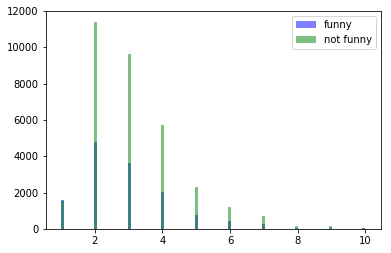

In [35]:
plt.hist(df[df.is_funny].n_scence_charcteres, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].n_scence_charcteres, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

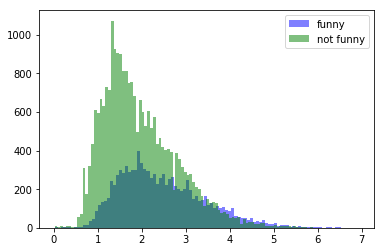

In [46]:
plt.hist(df[df.is_funny].length, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].length, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

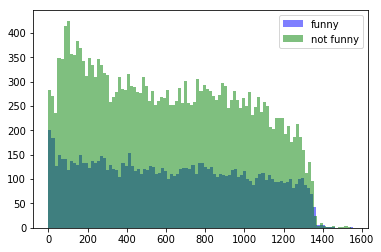

In [45]:
plt.hist(df[df.is_funny].start, bins=100, alpha=0.5, color='b', label='funny')
plt.hist(df[~df.is_funny].start, bins=100, alpha=0.5, color='g', label='not funny')
plt.legend()
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "start", bins=50, color='b')
plt.show()

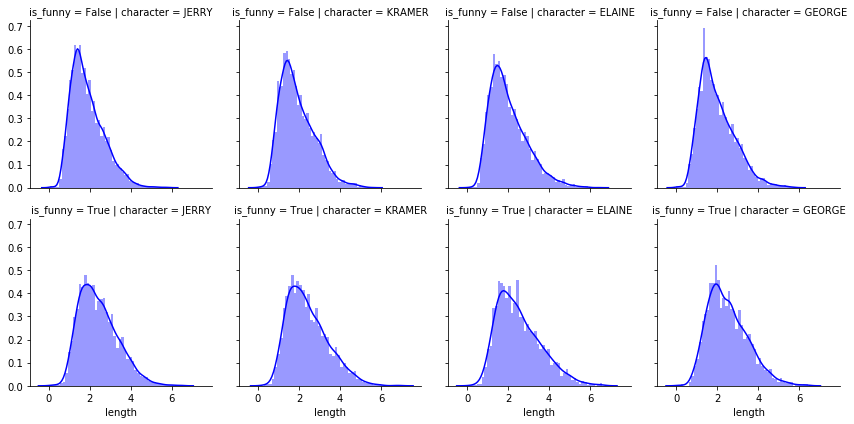

In [15]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "length", bins=50, color='b')
plt.show()

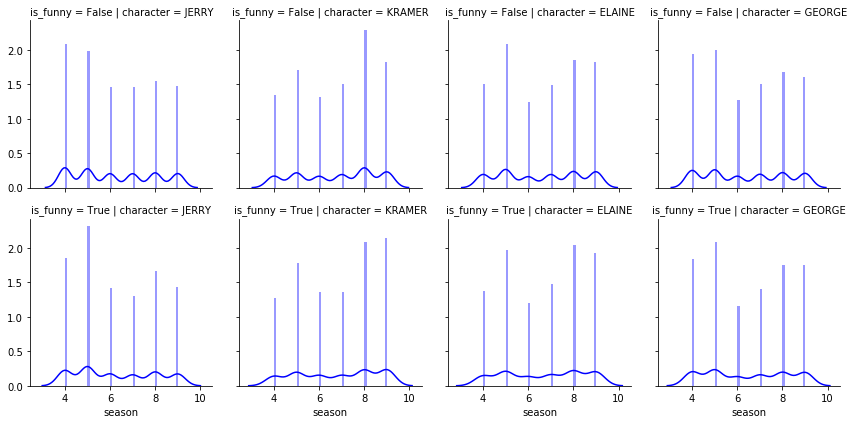

In [49]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "season", bins=50, color='b')
plt.show()

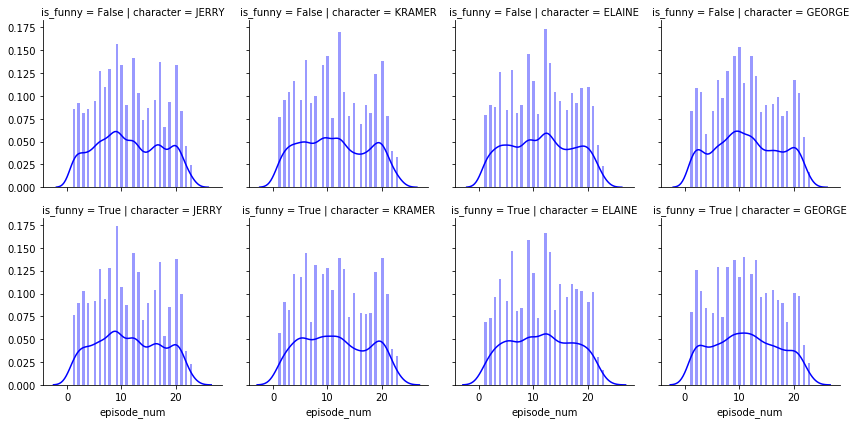

In [50]:
g = sns.FacetGrid(df, col='character', row='is_funny')
g.map(sns.distplot, "episode_num", bins=50, color='b')
plt.show()

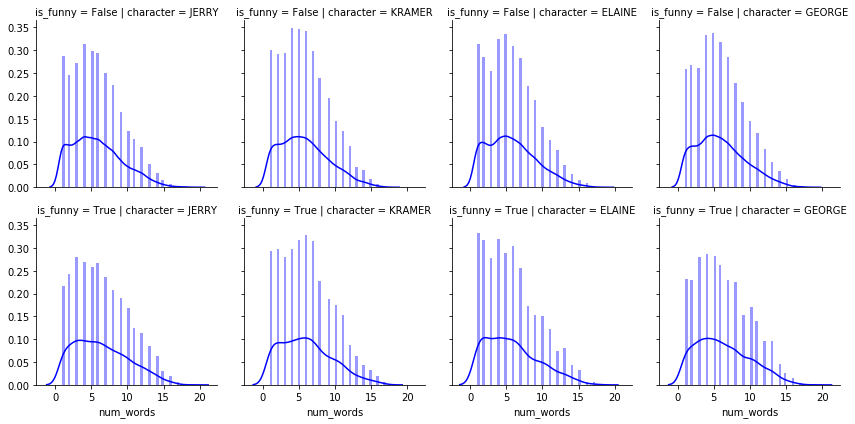

In [48]:
g2 = sns.FacetGrid(df, col='character', row='is_funny')
g2.map(sns.distplot, "num_words", bins=50, color='b')
plt.show()